## Spatial dynamics

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import  solve_ivp
from scipy.special import erf
from math import sqrt
from scipy.ndimage import laplace, convolve1d
import seaborn as snsb

In [163]:
def dydt_spatial(t, y, alpha, dx, r_d, p, mean, secondmoment, K, D):
    y = y.reshape((-1, len(alpha)))
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da, axis=-1)
    alpharho = alpha * y
    cutoff = np.heaviside(y - 1/K, .5)
    # dy = alpharho + v * convolve1d(alpharho, [1, -2, 1], axis=-1, mode='mirror')
    # dy[:, -1] = alpharho[:, -1] - v * da * (y[:, -2] + alpha[-2] * (y[:, -1] - y[:, -3]) / 2 / da)  # zero flux boundary conditions
    dy = cutoff * alpharho + p * (-mean * np.gradient(alpharho, da, axis=1) + secondmoment / 2 * convolve1d(alpharho, [1., -2., 1.], axis=1) / da**2)

    dy *= (1 - rho[..., None])
    dy -= r_d * y * cutoff
    dy[:, 0] = 0 # Dirichlet, Robin and Neumann boundary amounts to the same at the left boundary
    dy[:, -1] = 0  # neumann condition
    dy += convolve1d(y, [1., -2., 1.], axis=0, mode='mirror') / dx**2 * D
    return dy.flatten()

In [180]:
a_max = 1.
a_min = 0.
na = 1001
alpha, dalpha = np.linspace(a_min, a_max, num=na, retstep=True)
r_d = 0.01
r_b = 0.2
p_mut = 1
var = 0.00001
tmax = 50000
Da = var / 2
dens0 = 1 - r_d / r_b
ts = np.linspace(0, tmax, num=101)
nx = 100
xmax = 100
x, dx = np.linspace(0, xmax, nx, retstep=True, endpoint=False)
da = dalpha
p_m = 1
D = 0.00001
K = 1e6
dt = 1
Tfill = xmax / (2 * np.sqrt(D* (1.-r_d)))
tshow = [2, 10, 40, 100]
print(Tfill)

15891.043154093204


In [181]:
# cancer params
# p_l = 1e-8
# T_d = 2000
# T_p = 1e6
# p_d = T_d * p_l
# p_p = T_p * p_l
# p_mut = 1 - (1 - p_d) * (1 - p_p)
# p_pos = T_d / (T_d + T_p)
# s_p = 1e-2 * r_b
# s_d = 0.2 * r_b
# mean_mut_effect = p_pos * s_d - (1 - p_pos) * s_p
# var = p_pos * s_d**2 + (1 - p_pos) * s_p**2
# secondmommu = var + mean_mut_effect**2

In [182]:
method = 'RK45'

In [183]:
y0 = np.zeros((nx, na))
y0[0, np.argmin(np.abs(alpha - r_b))] = dens0 / da
solspatial = solve_ivp(dydt_spatial, (0, tmax), y0.flatten(), t_eval=ts, args=(alpha, dx, r_d, p_mut, mean_mut_effect, var, K, D), method=method)
print(solspatial.message)

The solver successfully reached the end of the integration interval.


### Definitions of observables:
$$\rho(\alpha, t) = \int_L \psi(x, \alpha, t) dx$$
$$\Psi (x, t) = \int_A \psi(x, \alpha, t) d\alpha$$
$$\langle \alpha \rangle (x, t) = \frac{\int_A \alpha \psi(x, \alpha, t) d\alpha}{\int_A \psi(x, \alpha, t) d\alpha}$$


In [184]:
y = solspatial.y.reshape((nx, na, len(solspatial.t)))
rhotot = np.trapz(y, dx=da, axis=1)  # total cell density at each point x
meanalpha = np.divide(np.trapz(alpha[None, ..., None] * y, dx=da, axis=1), rhotot, where=rhotot>1e-6, out=np.zeros_like(rhotot))  # mean alpha at each point x
rhoalpha = np.trapz(y, dx=dx, axis=0) / np.trapz(rhotot, dx=dx, axis=0)  # alpha distribution at each time t
meanalphatot = np.trapz(np.trapz(alpha[None, ..., None] * y, dx=da, axis=1), dx=dx, axis=0) / np.trapz(rhotot, dx=dx, axis=0)  # mean alpha at each time t

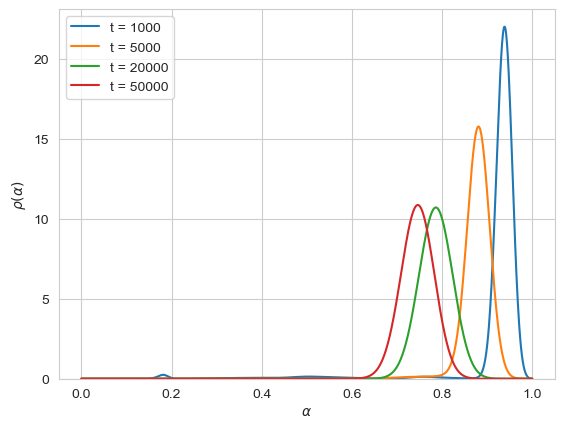

In [185]:
for t in tshow:
    pl = plt.plot(alpha, rhoalpha[:, t], label='t = {:n}'.format(ts[t]))
#     plt.plot(alpha, sol2.y[:, t], '--', c=pl[0].get_color())
#     plt.plot(alpha, sol3.y[:, t], '-.', c=pl[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.legend()

Text(0, 0.5, '$\\Psi (x)$')

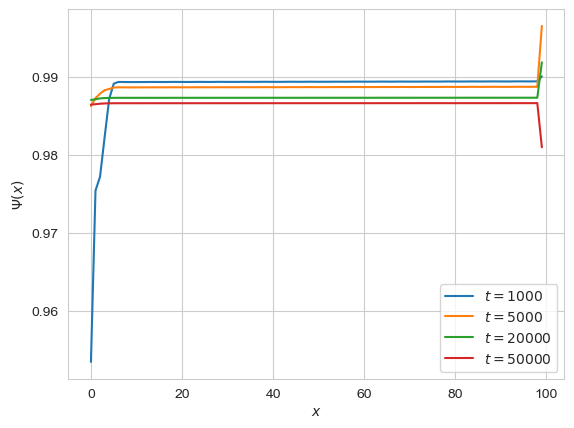

In [186]:
for t in tshow:
    plt.plot(x, rhotot[..., t], label='$t = {:n}$'.format(ts[t]))

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\Psi (x)$')

Text(0, 0.5, '$\\langle\\alpha\\rangle (x, t)$')

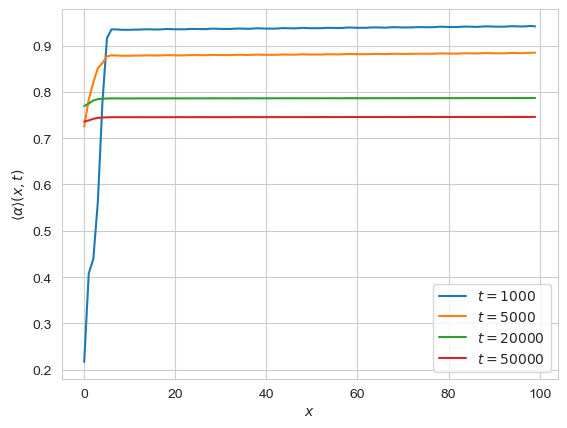

In [187]:
for t in tshow:
    plt.plot(x, meanalpha[..., t], label='$t = {:n}$'.format(ts[t]))

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\\langle\\alpha\\rangle (x, t)$')

Text(0, 0.5, '$\\langle\\alpha\\rangle(t)$')

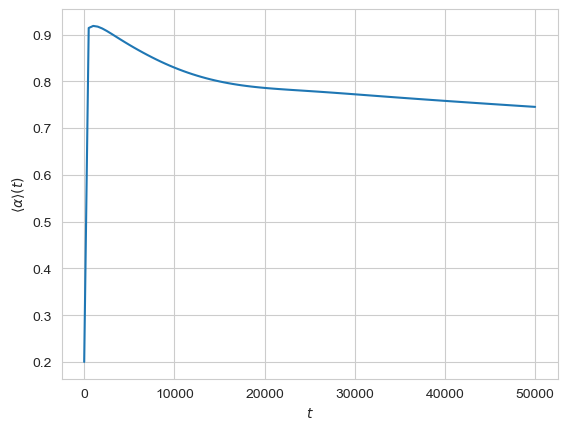

In [188]:
plt.plot(ts, meanalphatot)
plt.xlabel('$t$')
plt.ylabel('$\\langle\\alpha\\rangle(t)$')

In [173]:
def meanalphaana(t, alpha0, p_m, var):
    return alpha0 * np.cosh(np.sqrt(p_m * var) * t)

In [174]:
rb_ana = meanalphaana(ts, r_b, p_m, var)

In [175]:
meanalphafront = [meanalpha[np.argmax(rhotot[:, t], axis=0), t] for t in range(len(ts))]

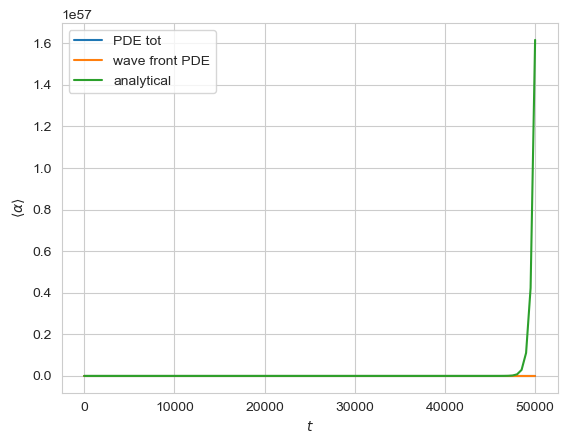

In [176]:
plt.plot(ts, meanalphatot, label='PDE tot')
plt.plot(ts, meanalphafront, label='wave front PDE')
plt.plot(ts, rb_ana, label='analytical')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.xlabel('$t$')
plt.legend()

In [177]:
# next: compare to cosh prediction, calc wave speed, compare wavespeed to lgca wavespeed over time!
# calculating the wave speed directly from data is very noisy. Strategy: interpolate the function, define a wave front, find the position of the wavefront
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, root

In [178]:
x.shape, rhotot.shape

((100,), (100, 101))

In [179]:
rhointerp = [interp1d(x, rhotot[:,t]-.5, fill_value='extrapolate') for t in range(tmax)]
# wavefront = [fsolve(rhoi, xmax/2) for rhoi in rhointerp]
# wavefront = fsolve(rhointerp, xmax/2)
frontindx = np.argmax(rhotot, axis=0)
# wavefront = x[np.argmin(np.gradient(rhotot, dx, axis=0), axis=0)]
wavefront = x[frontindx]

speed = np.gradient(wavefront, dt)
wavefront

IndexError: index 101 is out of bounds for axis 1 with size 101

In [ ]:
plt.plot(ts, speed)
plt.plot(ts, 2 * np.sqrt(D * rb_ana))

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    p = plt.plot(x, rhotot[..., t], lw=0, marker='x', label='$t = {:n}$'.format(ts[t]))
    plt.plot([wavefront[t], wavefront[t]], [0, 1], '--', color=p[0].get_color())

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\Psi (x)$')

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    pl = plt.plot(alpha, rhoalpha[:, t], label='t = {:n}'.format(ts[t]))
    plt.plot(alpha, y[frontindx[t], :, t], '--', color=pl[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.legend()
#plt.savefig('rho_alpha.png', dpi=600)

In [ ]:
# D = b / K = 2 / K -> K = 2 / D
nodes = np.zeros((xmax, 3), dtype=bool)
nodes[0, ...] = round(dens0 / 3 * K)
lgca2 = get_lgca(ib=True, nodes=nodes, bc='reflect', interaction='birthdeath', std=sqrt(var), ve=0, capacity=K,
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1000, restchannels=1)
lgca2.timeevo(timesteps=tmax, record=True)

In [ ]:
lgca2.plot_density()

In [ ]:
lgca2.nodes_t.shape

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    pl = plt.plot(alpha, rhoalpha[:, t], label='t = {:n}'.format(ts[t]))
    bins = round(np.ceil(np.log2(lgca2.dens_t[t].sum()))+1)
# plt.hist(np.array(lgca.props['r_b'])[lgca.nodes[lgca.nodes > 0]], bins=bins, density=True, label='LGCA')
    # plt.hist(lgca2.get_prop(nodes=lgca2.nodes_t[t][lgca2.nodes_t[t] > 0]), bins=bins, density=True, color=pl[0].get_color())
    plt.hist(lgca2.get_prop(nodes=lgca2.nodes_t[t]), bins=bins, density=True, color=pl[0].get_color())

#     plt.plot(alpha, sol2.y[:, t], '--', c=pl[0].get_color())
#     plt.plot(alpha, sol3.y[:, t], '-.', c=pl[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.xlim(0)
plt.legend()

In [ ]:
meanalphalgca = np.empty_like(meanalphatot)
for t in range(tmax+1):
    nodes = lgca2.nodes_t[t]
    # meanalphalgca[t] = np.mean(lgca2.get_prop(nodes[nodes>0]))
    meanalphalgca[t] = np.mean(lgca2.get_prop(nodes))

In [ ]:
lgca2.dens_t.shape

In [ ]:
meanalphalgca# = meanalphalgca[..., 0]

In [ ]:
plt.plot(ts, meanalphatot, label='PDE tot')
plt.plot(ts, rb_ana, label='analytical')
plt.plot(meanalphalgca, label='LGCA')
plt.plot(ts, meanalphafront, label='wave front PDE')
# lgca2.plot_prop_timecourse(label='LGCA')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.xlabel('$t$')
plt.legend()

In [ ]:
lgca2.dens_t.shape

In [ ]:
ts

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    p = plt.plot(x, rhotot[..., t], label='$t = {:n}$'.format(ts[t]))
    # plt.plot([wavefront[t], wavefront[t]], [0, 1], '-.', color=p[0].get_color())
    plt.plot(range(xmax), lgca2.dens_t[t]/lgca2.K, '-.', color=p[0].get_color())

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\Psi (x)$')
plt.xlim(0, 300)

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    plt.plot(x, meanalpha[..., t], label='$t = {:n}$'.format(ts[t]))

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\\langle\\alpha\\rangle (x)$')